In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import re
import numpy as np
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from heapq import nlargest 
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("csv/real_fake.csv")


In [0]:
df = df.set_index("Unnamed: 0") 

In [0]:
y = df['Label']

X_train, X_test, y_train, y_test = model_selection.train_test_split(df['text'], y, test_size=0.35, random_state=53)

In [0]:
def get_words(sentence):
    ignore = ['a','an','the','is','in','ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'am', 'or', 'who', 'as', 'from', 'him', 'each','would','also','like','could']
    words = re.sub("[^A-Za-z0–9\w]", " ",  sentence).split()
    
    cleaned_text = [w.lower() for w in words if w not in ignore]    
    return cleaned_text

In [0]:
def tokenize(Text):
    w = []
    for index in range(len(Text)):
    
        w.append(get_words(Text.iloc[index]))
    return w

In [0]:
stop_words = set(stopwords.words('english')) 

In [0]:
X_train_dict = np.asanyarray(tokenize(X_train))
dict_of_words = {}

for i in X_train_dict:
    for words in i:
        if(len(words)>2):
            if dict_of_words.get(words)!=None:
                dict_of_words[words]=dict_of_words.get(words)+1
            elif words in stop_words:
                continue
            else:
                dict_of_words[words]=1
            
dict_of_words = {k: v for k, v in sorted(dict_of_words.items(), key=lambda item: item[1],reverse=True)}

In [0]:

len_Xtrain = X_train_dict.shape[0]

y_temp = list(y_train)

In [0]:
count_of_words_in_real = 0;
listrealCounts = [];
dict_words_real={};
for i in range(len_Xtrain):
      
      if (y_temp[i]) =='REAL':
            for words in X_train_dict[i]:
                if words in dict_of_words:
                    count_of_words_in_real+=1
                    if words in dict_words_real:
                        dict_words_real[words]= dict_words_real.get(words)+1;
                    else:
                        dict_words_real[words]=1;

#dict_words_real1['floor']

In [0]:
count_of_words_in_fake = 0;
listrealCounts = [];
dict_words_fake={};
for i in range(len_Xtrain):
      
      if (y_temp[i]) =='FAKE':
            for words in X_train_dict[i]:
                if words in dict_of_words:
                    count_of_words_in_fake+=1
                    if words in dict_words_fake:
                        dict_words_fake[words]= dict_words_fake.get(words)+1;
                    else:
                        dict_words_fake[words]=1;


In [0]:
dict_words_fakeSet = set(dict_words_fake)
dict_words_realSet = set(dict_words_real)

prior_real = len(dict_words_realSet)/(len(dict_words_fakeSet)+len(dict_words_realSet))
prior_fake = len(dict_words_fakeSet)/(len(dict_words_fakeSet)+len(dict_words_realSet))


In [0]:
def common_count_generator(val,val_compared_with,val_comp):
    common={}
   
    for name in val.intersection(val_compared_with):
        if name in common:
            common[name]= common.get(name)+1;
        else:
            common[name]=val_comp.get(name)

    return common

In [0]:
common_real = common_count_generator(dict_words_fakeSet,dict_words_realSet,dict_words_real)
common_fake = common_count_generator(dict_words_realSet,dict_words_fakeSet,dict_words_fake)


In [0]:
real_probabs = {k: v / sum(common_real.values(), 0.0) for k, v in common_real.items()}
fake_probabs = {k: v / sum(common_fake.values(), 0.0) for k, v in common_fake.items()}

In [0]:
common_words = dict.fromkeys(common_fake, 0)

In [0]:
res_real = nlargest(20, common_real, key = common_real.get)
res_fake = nlargest(20,common_fake, key= common_fake.get)

In [0]:
val_real = []
val_fake = []
for word in res_real:
  val_real.append(common_real.get(word))
for word in res_fake:
  val_fake.append(common_fake.get(word))

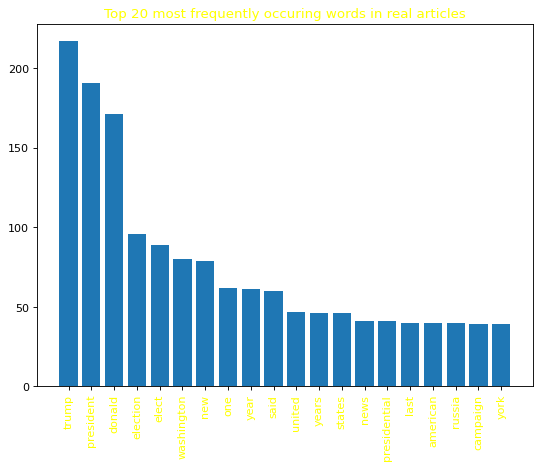

In [19]:
height = val_real
bars = (res_real)
y_pos = np.arange(len(bars))
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(y_pos, height)
plt.xticks(y_pos, bars,rotation = 'vertical',color='Yellow')
plt.title('Top 20 most frequently occuring words in real articles',color='Yellow')
plt.show()

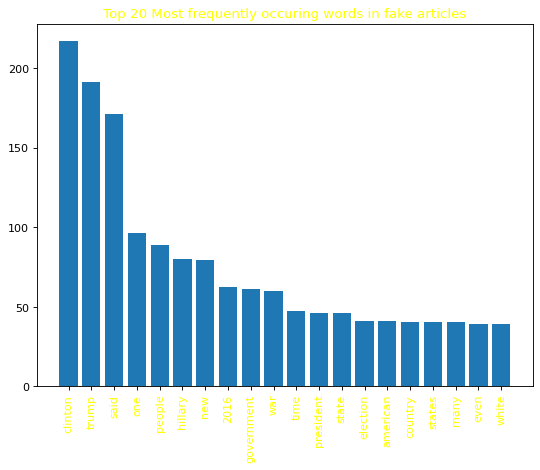

In [20]:
sht = val_fake
bars_t = (res_fake)
y_pos_1 = np.arange(len(bars))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Top 20 Most frequently occuring words in fake articles',color = 'Yellow')
plt.bar(y_pos_1, height)
plt.xticks(y_pos_1, bars_t,rotation = 'vertical',color='Yellow')
plt.show()


In [0]:

X_test_dict = np.asanyarray(tokenize(X_test))
count_per_article = {}

correct_count = 0
predictions = []
acc = []
for idx,i in enumerate(X_test_dict):
 
  prob_r=0
  prob_f=0
  c = common_words
  for words in i:
        if(len(words)>2):
          if words in common_words.keys():
            c[words]=c.get(words)+1

            prob_r += np.log2(real_probabs[words])*np.log2(1+ c[words])
            prob_f += np.log2(fake_probabs[words])*np.log2(1+ c[words]) 

  prob_r = prob_r + np.log2(prior_real)
  prob_f = prob_f + np.log2(prior_fake) 
  
  
  assigned_class= None;
  if(prob_r>prob_f):
    res = 'REAL'
    if(y_test.iloc[idx]== 'REAL'):
      correct_count+=1
    
  else:
    res = 'FAKE'
    if(y_test.iloc[idx]== 'FAKE'):
      correct_count+=1
    assigned_class = 'FAKE'
   
  accuracy= correct_count/len(X_test_dict) *100
  acc.append(accuracy)
  predictions.append(res)
  

array([[182, 135],
       [  9, 298]])

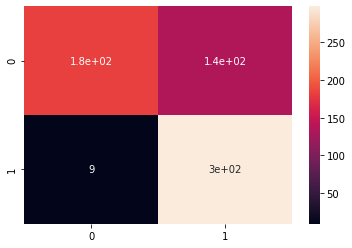

In [33]:
cf_matrix = confusion_matrix(y_test, predictions, labels=["REAL", "FAKE"])
sns.heatmap(cf_matrix, annot=True)

cf_matrix

In [34]:
accuracy= correct_count/len(X_test_dict) *100
accuracy

76.92307692307693

In [0]:
plt.plot(acc)